In [1]:
import chess
import chess.svg

from IPython.display import SVG

board = chess.Board()
SVG(chess.svg.board(board=board,size=400)) #show board at jupyter notebook

import pandas as pd
chess_game = pd.read_csv("dataset/games.csv", index_col=0)

dataset = []
#for i in range(1000):
for i in range(len(chess_game)):
    x = chess_game.iloc[i][11]
    x = x.split()
    array_move = []
    for j in x:
        list_square = []
        a = board.push_san(j)
        list_square.append(a.from_square)
        list_square.append(a.to_square)
        array_move.append(list_square)
    dataset.append(array_move)
    board = chess.Board()
    #print("%d 번째"%i, "게임 코드", array_move)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
chess_game.head()

chess_game.shape #(20058, 15)

(20058, 15)

In [4]:
dpp_ds = [] #datapreprocessing dataset
for i in dataset:
    a = []
    for j in i:
        for k in j:
            a.append(k)
    dpp_ds.append(a)

#dpp_ds = np.array(dpp_ds, dtype = object)

In [5]:
#all_data = np.array([])
all_data = []
print(np.array(dpp_ds[0]))
for i in dpp_ds:
    a = np.array(i)
    all_data = np.append(all_data, a)
    
all_data = all_data[:1000]

[11 27 51 35 10 26 50 42 26 35 52 44 35 44 53 44  6 21 61 25  1 18 25 32
  2 29]


In [6]:
test_data_size = 500
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]



print(len(train_data))
print(len(test_data))

500
500


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1,1))

In [8]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [9]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])
print(len(train_data_normalized))

tensor([-0.6508, -0.1429,  0.6190,  0.1111, -0.6825])
tensor([ 0.0794, -0.8095, -0.3333,  0.8730,  0.0159])
500


In [10]:
train_window = 20

In [11]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [12]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [13]:
train_inout_seq[:5]

[(tensor([-0.6508, -0.1429,  0.6190,  0.1111, -0.6825, -0.1746,  0.5873,  0.3333,
          -0.1746,  0.1111,  0.6508,  0.3968,  0.1111,  0.3968,  0.6825,  0.3968,
          -0.8095, -0.3333,  0.9365, -0.2063]),
  tensor([-0.9683])),
 (tensor([-0.1429,  0.6190,  0.1111, -0.6825, -0.1746,  0.5873,  0.3333, -0.1746,
           0.1111,  0.6508,  0.3968,  0.1111,  0.3968,  0.6825,  0.3968, -0.8095,
          -0.3333,  0.9365, -0.2063, -0.9683]),
  tensor([-0.4286])),
 (tensor([ 0.6190,  0.1111, -0.6825, -0.1746,  0.5873,  0.3333, -0.1746,  0.1111,
           0.6508,  0.3968,  0.1111,  0.3968,  0.6825,  0.3968, -0.8095, -0.3333,
           0.9365, -0.2063, -0.9683, -0.4286]),
  tensor([-0.2063])),
 (tensor([ 0.1111, -0.6825, -0.1746,  0.5873,  0.3333, -0.1746,  0.1111,  0.6508,
           0.3968,  0.1111,  0.3968,  0.6825,  0.3968, -0.8095, -0.3333,  0.9365,
          -0.2063, -0.9683, -0.4286, -0.2063]),
  tensor([0.0159])),
 (tensor([-0.6825, -0.1746,  0.5873,  0.3333, -0.1746,  0.1111,  

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [15]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

print('cuda index:', torch.cuda.current_device())

print('gpu 개수:', torch.cuda.device_count())

print('graphic name:', torch.cuda.get_device_name())

cuda = torch.device('cuda')

print(cuda)

True
학습을 진행하는 기기: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: GeForce GTX 1660 SUPER
cuda


In [18]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels).to(device)
        single_loss.backward()
        optimizer.step()

    if i%15 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.14470465
epoch:  16 loss: 0.02207586
epoch:  31 loss: 0.29895565
epoch:  46 loss: 0.00255642
epoch:  61 loss: 0.00521289
epoch:  76 loss: 0.00955234
epoch:  91 loss: 0.00371627
epoch: 106 loss: 0.03800691
epoch: 121 loss: 0.11076590
epoch: 136 loss: 0.00244868
epoch: 149 loss: 0.0236213207


In [20]:
fut_pred = 100

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.1428571492433548, -0.1111111119389534, 0.523809552192688, 0.682539701461792, 0.1746031790971756, 0.2063492089509964, 0.8095238208770752, 0.9682539701461792, 0.2063492089509964, 0.4920634925365448, 0.682539701461792, 0.7460317611694336, -0.6190476417541504, -0.1111111119389534, 0.5873016119003296, 0.0793650820851326, -0.8095238208770752, -0.3333333432674408, 0.8730158805847168, 0.01587301678955555]


In [21]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [22]:
test_inputs[fut_pred:]

[-0.7851424217224121,
 -0.3665168285369873,
 0.7313687801361084,
 0.4803788363933563,
 -0.7418724894523621,
 0.20738357305526733,
 0.6159735321998596,
 0.3396525979042053,
 -0.1588054746389389,
 0.14438565075397491,
 0.5370858907699585,
 0.3586978614330292,
 0.05493130534887314,
 0.1482516974210739,
 0.4488318860530853,
 0.22341954708099365,
 -0.7309478521347046,
 -0.26041826605796814,
 0.23797892034053802,
 0.06733642518520355]

In [23]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[ 8.13277209]
 [21.99687445]
 [50.43599707]
 [41.38520622]
 [ 9.00885209]
 [25.25470456]
 [41.89562188]
 [29.08253755]
 [ 9.07849967]
 [17.0282983 ]
 [54.63534719]
 [43.89411972]
 [ 8.58313912]
 [21.67477199]
 [60.55349332]
 [44.79357049]
 [ 2.40017822]
 [13.05611157]
 [59.49214268]
 [47.7500563 ]
 [ 8.09272778]
 [16.15619588]
 [52.42158678]
 [46.46328275]
 [18.33908661]
 [19.20379244]
 [56.08612347]
 [43.43052819]
 [ 8.54570273]
 [19.38960193]
 [51.22145355]
 [41.97089835]
 [ 8.16336107]
 [20.0384519 ]
 [45.59310387]
 [41.74595985]
 [16.99080746]
 [24.73019557]
 [52.48765576]
 [41.21609093]
 [ 7.92306894]
 [15.75608701]
 [48.86045972]
 [37.14834648]
 [ 3.76461178]
 [14.78015533]
 [44.63354816]
 [41.52031258]
 [18.78434671]
 [26.2195207 ]
 [50.40310621]
 [44.06844051]
 [19.04396161]
 [28.02420647]
 [50.24117723]
 [29.88389192]
 [10.65725327]
 [23.89490573]
 [36.92444111]
 [27.94354098]
 [ 9.26791969]
 [19.29455303]
 [34.86544896]
 [36.64812731]
 [17.80659382]
 [18.14511824]
 [33.32126

In [29]:
move_pred = []
for i in actual_predictions:
    a = round(float(i))
    move_pred.append(a)
    print(round(float(i)))
move_pred

8
22
50
41
9
25
42
29
9
17
55
44
9
22
61
45
2
13
59
48
8
16
52
46
18
19
56
43
9
19
51
42
8
20
46
42
17
25
52
41
8
16
49
37
4
15
45
42
19
26
50
44
19
28
50
30
11
24
37
28
9
19
35
37
18
18
33
37
16
19
33
44
28
27
38
46
25
23
43
47
7
20
55
47
8
38
51
42
26
36
48
43
33
36
46
39
8
23
39
34


[8,
 22,
 50,
 41,
 9,
 25,
 42,
 29,
 9,
 17,
 55,
 44,
 9,
 22,
 61,
 45,
 2,
 13,
 59,
 48,
 8,
 16,
 52,
 46,
 18,
 19,
 56,
 43,
 9,
 19,
 51,
 42,
 8,
 20,
 46,
 42,
 17,
 25,
 52,
 41,
 8,
 16,
 49,
 37,
 4,
 15,
 45,
 42,
 19,
 26,
 50,
 44,
 19,
 28,
 50,
 30,
 11,
 24,
 37,
 28,
 9,
 19,
 35,
 37,
 18,
 18,
 33,
 37,
 16,
 19,
 33,
 44,
 28,
 27,
 38,
 46,
 25,
 23,
 43,
 47,
 7,
 20,
 55,
 47,
 8,
 38,
 51,
 42,
 26,
 36,
 48,
 43,
 33,
 36,
 46,
 39,
 8,
 23,
 39,
 34]

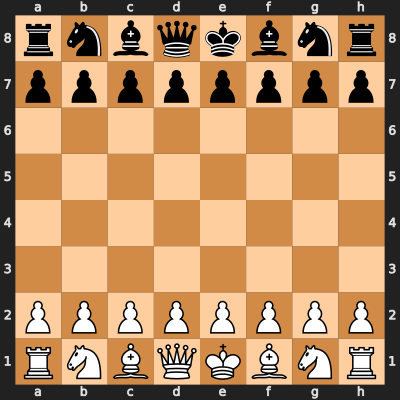

In [30]:
board = chess.Board()
SVG(chess.svg.board(board=board,size=400))

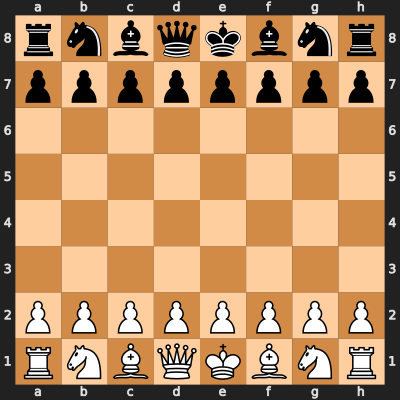

In [33]:
chess.Move(8, 24)
SVG(chess.svg.board(board=board,size=400))